In [36]:
#Importing Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam, Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report 

from IPython.display import Image
import keras.backend as K
import splitfolders

import warnings
warnings.filterwarnings("ignore")

print ('All Modules Are Loaded')

All Modules Are Loaded


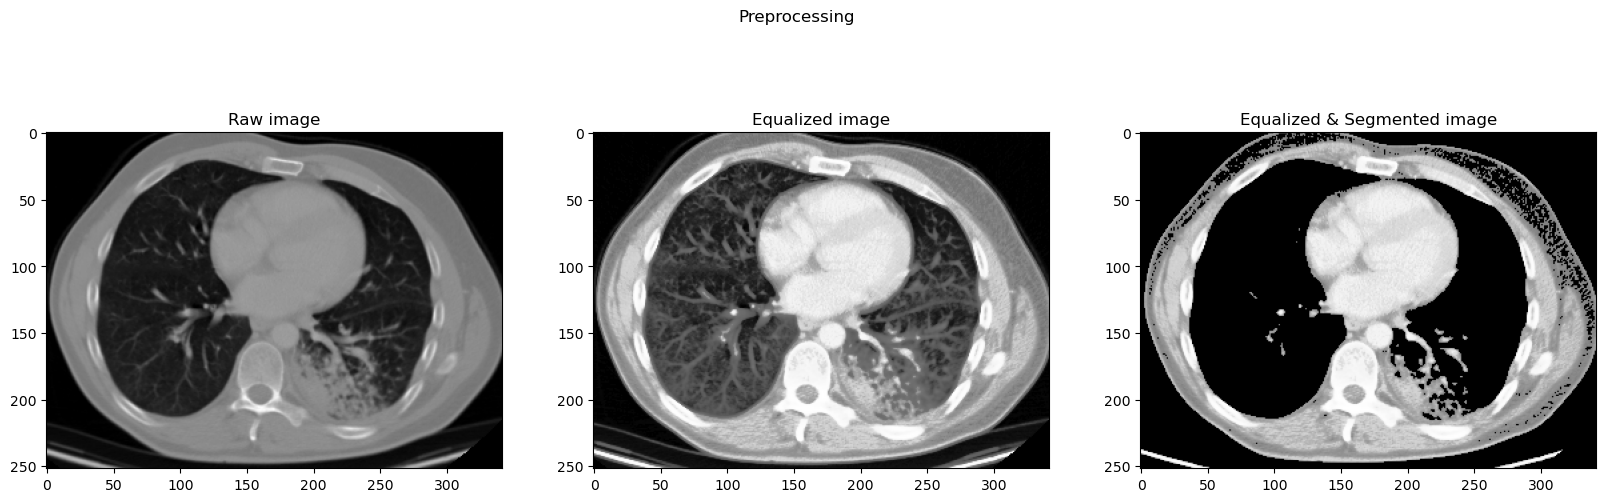

In [37]:
#Preprocessing the image by histogram equalization and segmentation 
img = cv2.imread(r'C:\Users\Narmin\OneDrive\Project\AI-powered-health-analysis-platform\Lung Cancer\rawData\squamous.cell.carcinoma\squamous.cell.carcinoma1.png', 0)
equalizedImage = cv2.equalizeHist(img)
e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Raw image')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(equalizedImage, cv2.COLOR_BGR2RGB))
ax2.set_title('Equalized image')

ax3 = plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
ax3.set_title('Equalized & Segmented image')

plt.suptitle('Preprocessing')

plt.show()

In [38]:
print(os.getcwd(), os.listdir())
DIR = r'C:\Users\Narmin\OneDrive\Project\AI-powered-health-analysis-platform\Lung Cancer\rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = r'C:\Users\Narmin\OneDrive\Project\AI-powered-health-analysis-platform\Lung Cancer\data'

c:\Users\Narmin\OneDrive\Project\AI-powered-health-analysis-platform\Lung Cancer ['data', 'lung.ipynb', 'processedData', 'rawData']


In [39]:
if not os.path.exists(DEST_DIR):
    os.makedirs(os.path.join(DEST_DIR, 'cancerous'), exist_ok=True)
    os.makedirs(os.path.join(DEST_DIR, 'non-cancerous'), exist_ok=True)

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            imgDest = os.path.join(DEST_DIR, 'non-cancerous', image)
        else:
            imgDest = os.path.join(DEST_DIR, 'cancerous', image)
        cv2.imwrite(imgDest, segmentedImage)

print("Processed data directory created successfully at", DEST_DIR)


Processed data directory created successfully at C:\Users\Narmin\OneDrive\Project\AI-powered-health-analysis-platform\Lung Cancer\data


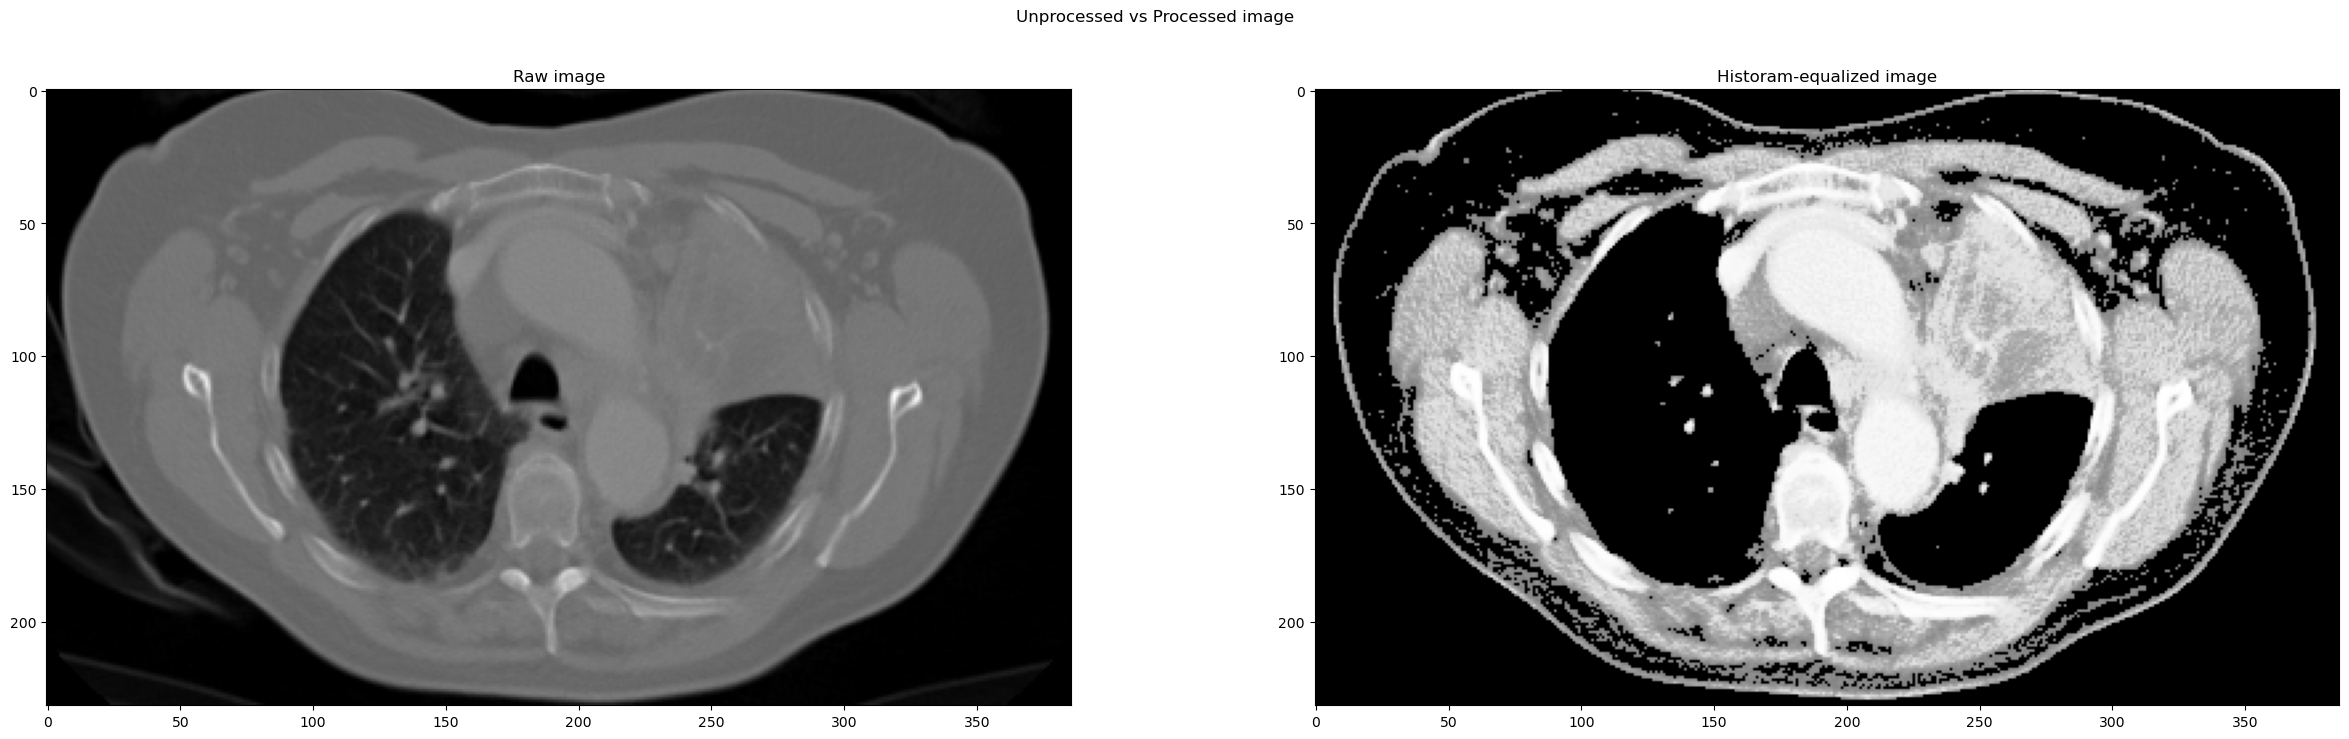

In [40]:
#Comparing the original and processed image 
plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(DIR, CATS[0], 'adenocarcinoma10.png')))
plt.title('Raw image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(os.path.join(DEST_DIR,'cancerous', 'adenocarcinoma10.png')))
plt.title('Historam-equalized image')
plt.suptitle('Unprocessed vs Processed image')
plt.show()

In [41]:
#splitting the processed images
FINAL_DIR = r'C:\Users\Narmin\OneDrive\Project\AI-powered-health-analysis-platform\Lung Cancer\processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2)) 

Copying files: 1000 files [00:20, 48.22 files/s]


In [42]:
BATCH_SIZE=32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,                  
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [43]:
train_dataset  = train_datagen.flow_from_directory(directory = r'C:\Users\Narmin\OneDrive\Project\AI-powered-health-analysis-platform\Lung Cancer\processedData\train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 699 images belonging to 2 classes.


In [44]:
valid_dataset = valid_datagen.flow_from_directory(directory = r'C:\Users\Narmin\OneDrive\Project\AI-powered-health-analysis-platform\Lung Cancer\processedData\val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 99 images belonging to 2 classes.


In [45]:
test_dataset = test_datagen.flow_from_directory(directory = r'C:\Users\Narmin\OneDrive\Project\AI-powered-health-analysis-platform\Lung Cancer\processedData\test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 202 images belonging to 2 classes.


In [50]:
def F1(y_true, y_pred):  # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='Precision'),
    tf.keras.metrics.Recall(name='Recall'),
    tf.keras.metrics.AUC(name='AUC'),
    F1,
]

def plot_history(hist, name):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(hist.history['Accuracy'])
    axs[0].plot(hist.history['val_Accuracy'])
    axs[0].set_title(f'{name} Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    axs[1].plot(hist.history['loss'])
    axs[1].plot(hist.history['val_loss'])
    axs[1].set_title(f'{name} Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='upper left')

    axs[2].plot(hist.history['Precision'])
    axs[2].plot(hist.history['val_Precision'])
    axs[2].set_title(f'{name} Precision')
    axs[2].set_ylabel('Precision')
    axs[2].set_xlabel('Epoch')
    axs[2].legend(['train', 'val'], loc='upper left')

    plt.show()

In [52]:
#Resnet50 Model
ResNet50_base = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in ResNet50_base.layers:
    layer.trainable = False

ResNet50=tf.keras.Sequential()
ResNet50.add(ResNet50_base)
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Flatten())
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dense(1,activation='sigmoid'))

ResNet50.summary()

ResNet50.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_31 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_11 (Flatten)        (None, 100352)            0         
                                                                 
 batch_normalization_40 (Bat  (None, 100352)           401408    
 chNormalization)                                                
                                                                 
 dense_43 (Dense)            (None, 32)                3211296   
                                                                 
 batch_normalization_41 (Bat  (None, 32)               128       
 chNormalization)                                    

In [53]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.50, min_lr=1e-7)

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

ResNet50_history = ResNet50.fit(train_dataset, validation_data=valid_dataset, epochs=36, verbose=1, callbacks=[lrd, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - 97s 4s/step - loss: 0.7260 - Accuracy: 0.5422 - Precision: 0.2529 - Recall: 0.5800 - AUC: 0.5597 - F1: 0.3335 - val_loss: 0.7286 - val_Accuracy: 0.5859 - val_Precision: 0.3148 - val_Recall: 0.8095 - val_AUC: 0.7302 - val_F1: 0.5422 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - 72s 3s/step - loss: 0.6116 - Accuracy: 0.6667 - Precision: 0.2995 - Recall: 0.4133 - AUC: 0.6148 - F1: 0.3393 - val_loss: 0.3792 - val_Accuracy: 0.8586 - val_Precision: 0.7333 - val_Recall: 0.5238 - val_AUC: 0.8745 - val_F1: 0.4575 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - 73s 3s/step - loss: 0.5365 - Accuracy: 0.7568 - Precision: 0.4091 - Recall: 0.3000 - AUC: 0.6747 - F1: 0.3183 - val_loss: 0.3859 - val_Accuracy: 0.8384 - val_Precision: 0.6667 - val_Recall: 0.4762 - val_AUC: 0.9399 - val_F1: 0.4248 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - 73s 3s/step - loss: 0.5002 - Accuracy: 0.7926 - Precision

In [54]:
# Calculating steps per dataset
train_steps = len(train_dataset)
valid_steps = len(valid_dataset)
test_steps = len(test_dataset)

# Evaluating
train_score = ResNet50.evaluate(train_dataset, steps=train_steps, verbose=1)
valid_score = ResNet50.evaluate(valid_dataset, steps=valid_steps, verbose=1)
test_score = ResNet50.evaluate(test_dataset, steps=test_steps, verbose=1)

# Printing results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 20s 3s/step - loss: 0.1990 - Accuracy: 0.9356 - Precision: 0.8605 - Recall: 0.8409 - AUC: 0.9783 - F1: 0.8620
Train Loss:  0.2520081400871277
Train Accuracy:  0.9227467775344849
--------------------
Valid Loss:  0.24711425602436066
Valid Accuracy:  0.8989899158477783
--------------------
Test Loss:  0.19895116984844208
Test Accuracy:  0.9356435537338257


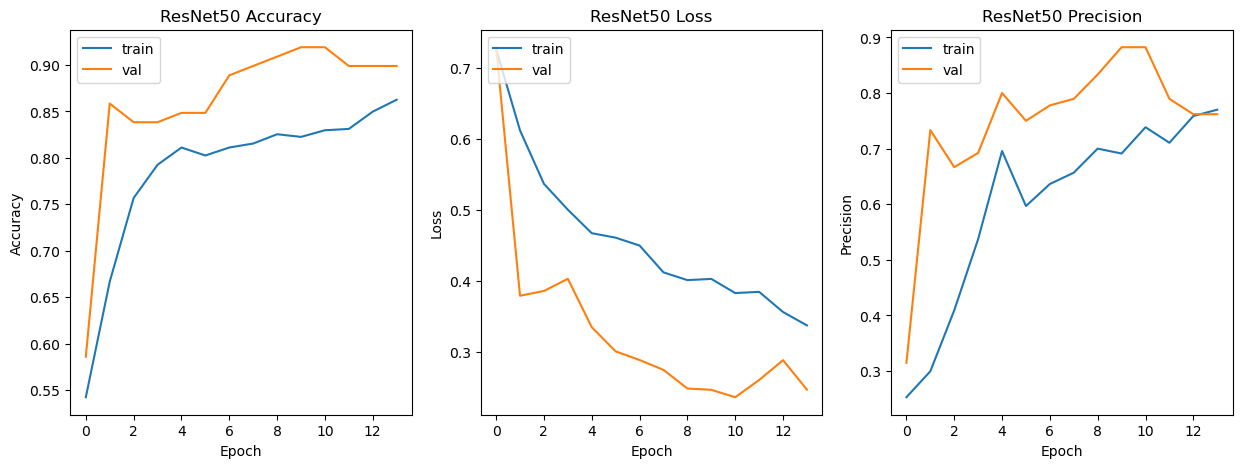

In [55]:
plot_history(ResNet50_history, 'ResNet50')

7/7 [==============================] - 15s 2s/step


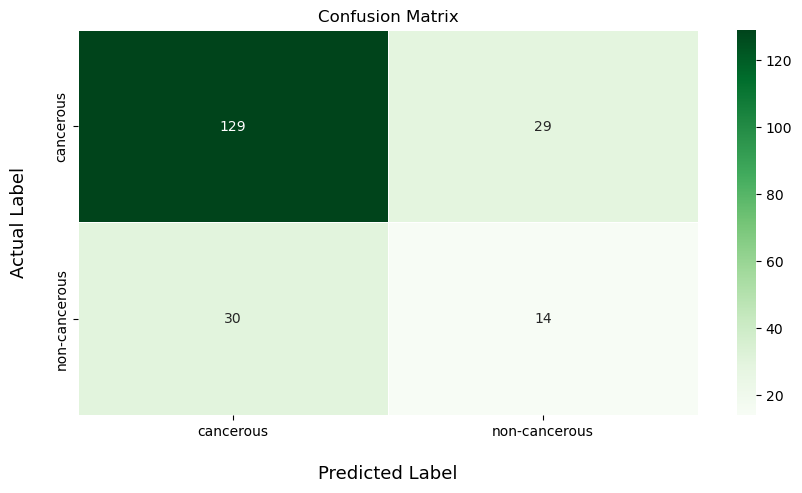

In [75]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix

# Getting true labels and predictions
y_true = test_dataset.classes
y_pred = (ResNet50.predict(test_dataset) > 0.5).astype("int32").flatten()

# Plotting the confusion matrix
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_true, y_pred)
labels = list(test_dataset.class_indices.keys())
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Greens", linewidths=.5)
plt.xlabel('\nPredicted Label', fontsize=13)
plt.ylabel('Actual Label\n', fontsize=13)
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


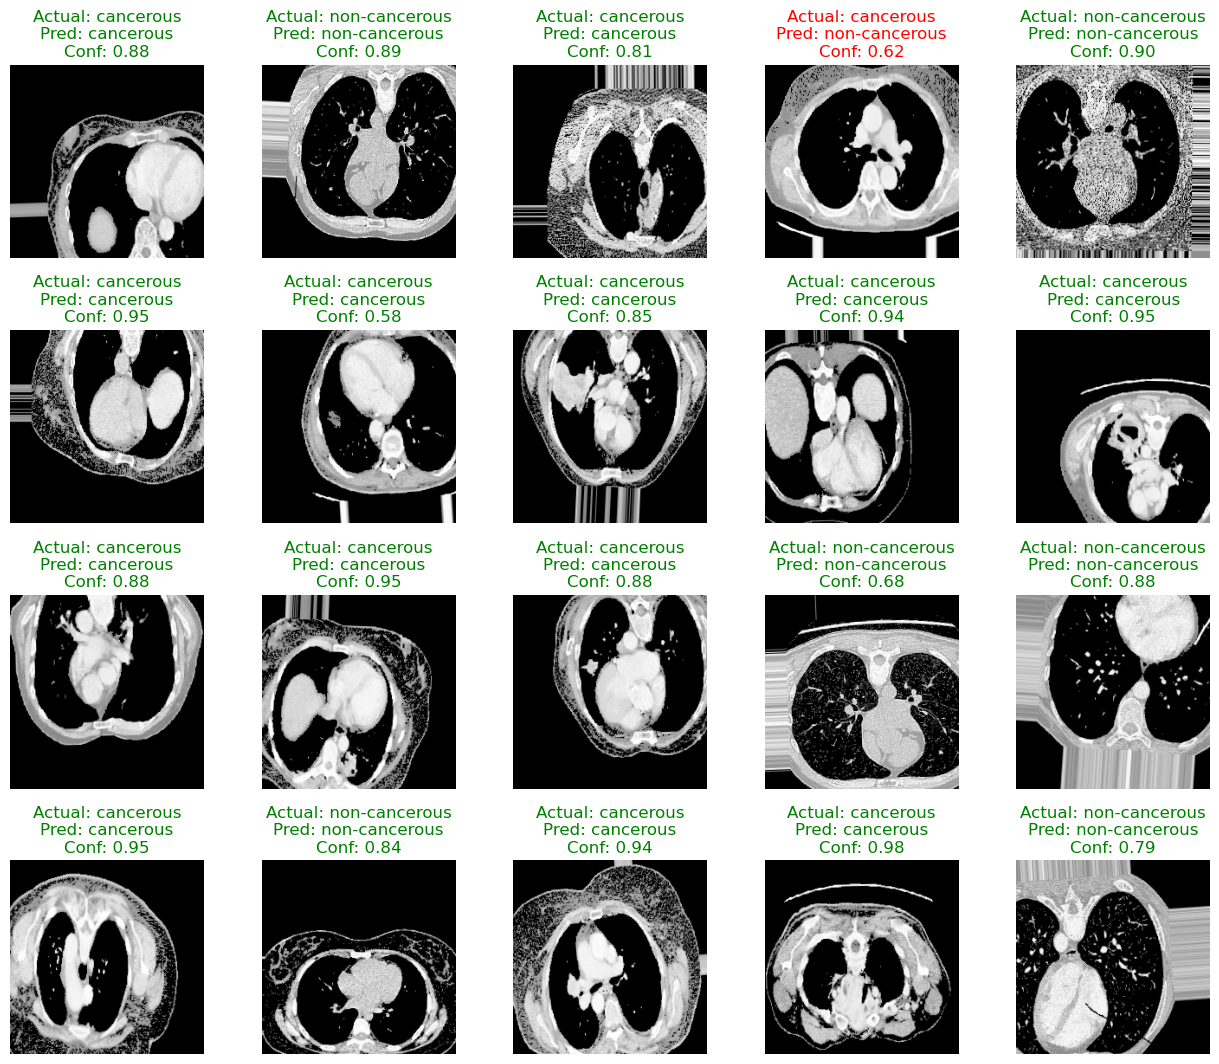

In [76]:
# Defining grid dimensions
grid_width = 5
grid_height = 4

# Randomly selecting images from the training dataset
random_indices = random.sample(range(len(train_dataset)), grid_width * grid_height)

f, ax = plt.subplots(grid_height, grid_width)
f.set_size_inches(12, 10)  # Adjusted size to reduce white space

for idx, img_idx in enumerate(random_indices):
    i, j = divmod(idx, grid_width)  # Calculating grid position
    images, labels_batch = train_dataset[img_idx]  # Fetching the batch
    actual = int(labels_batch[0])  # Getting the actual class index as an integer
    prediction = ResNet50.predict(images)
    predicted = int((prediction > 0.5).astype("int32")[0][0])  # Predicting the class as an integer
    confidence = prediction[0][0] if predicted == 1 else 1 - prediction[0][0]  # Calculating confidence
    ax[i][j].axis('off')
    if labels[actual] == labels[predicted]:
        ax[i][j].set_title(f'Actual: {labels[actual]}\nPred: {labels[predicted]}\nConf: {confidence:.2f}', color='green')
    else:
        ax[i][j].set_title(f'Actual: {labels[actual]}\nPred: {labels[predicted]}\nConf: {confidence:.2f}', color='red')

    ax[i][j].imshow(images[0])  # Displaying the image

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)


In [77]:
#Saving the Model
ResNet50.save('lung.h5')